# Kaggle competition: classify leaves

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns

In [2]:
train_data = pd.read_csv(r"D:/kaggle/competitions/classify-leaves/train.csv") # 训练数据
test_data = pd.read_csv(r"D:/kaggle/competitions/classify-leaves/test.csv") # 测试数据
print(train_data.shape)
print(test_data.shape)


(18353, 2)
(8800, 1)


In [3]:
train_data_path = 'D:/kaggle/competitions/classify-leaves/train.csv'
test_data_path ='D:/kaggle/competitions/classify-leaves/test.csv'
image_path = 'D:/kaggle/competitions/classify-leaves/images/'

In [4]:
labels_dataframe = pd.read_csv( 'D:/kaggle/competitions/classify-leaves/train.csv')
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
num_to_class = dict(zip(range(n_classes),leaves_labels))


In [5]:
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  
            #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]
        single_image_name = ''.join(filter(str.isdigit, single_image_name))
        single_image_name+='.jpg'
        #print(single_image_name)
        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label =   class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len


In [7]:
train_data = LeavesData(train_data_path,image_path,mode ='train' )
vaild_data = LeavesData(train_data_path,image_path,mode = 'valid')
test_data  = LeavesData(test_data_path,image_path,mode = 'test')

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


130


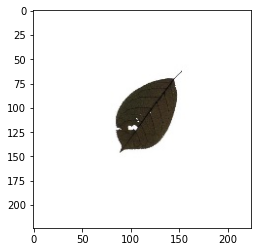

In [8]:
images,labels = train_data[112]
img=torchvision.utils.make_grid(images)
img=img.numpy().transpose(1,2,0)
print(labels)
plt.imshow(img)
plt.show()

In [9]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [10]:
data_loader_train=torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset =test_data,batch_size = 64,shuffle = False)
data_loader_valid = torch.utils.data.DataLoader(dataset = vaild_data,batch_size = 64,shuffle = True)

In [11]:

class ResNet34(nn.Module):
    """
    实现主module：ResNet34
    ResNet34包含多个layer，每个layer又包含多个Residual block
    用子module来实现Residual block，用_make_layer函数来实现layer
    """
 
    def __init__(self, num_classes=176):
        super(ResNet34, self).__init__()
        self.model_name = 'resnet34'
 
        # 前几层: 图像转换
        resnet34 = models.resnet34(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet34.children())[:-1])
        num_ftrs = resnet34.fc.in_features
        self.fc = nn.Linear(num_ftrs, out_features=num_classes)
 
 
    def forward(self, x):
 
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [11]:
resnet = ResNet34()
if torch.cuda.is_available():
    resnet = resnet.cuda()
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet.parameters(),lr=0.01)

In [13]:
def train():
    for data in data_loader_train:
        x_train, y_train = data
        y_hat = resnet(x_train)
        loss = loss_func(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch %d, loss %.4f' % (epoch + 1, loss))
    return loss  

In [14]:
def test():
    correct = 0
    for data in data_loader_test:
        x_test, y_test = data
        outputs = resnet(x_test)
        _, predict = torch.max(outputs.data, dim=1)
        correct += torch.sum(predict == y_test.data)
    correct = correct.detach().cpu().numpy()
    print("correct rate = ",100 * correct/len(vaild_data))
    return 100 * correct/len(vaild_data) *0.01

In [ ]:
lss = []
acc = []
epochs = []
for epoch in range(50):
    epochs.append(epoch+1)
    ls = train();
    ac = test();
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()

Because my computer's GPU is not work-well, I trained it on kaggle's notebook using its GPU. I saved trained model and used it to test. 

In [12]:
labels_dataframe = pd.read_csv( train_data_path)
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
num_to_class = dict(zip(range(n_classes),leaves_labels))


In [13]:
model_path = 'D:/chrome下载/pre_res_model2 (1).ckpt'
resnet1 = ResNet34(176)
resnet1 = resnet1.to(device)
resnet1.load_state_dict(torch.load(model_path))
resnet1.eval()

ResNet34(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [14]:
predictions = []
saveFileName = 'D:/kaggle/submission.csv'

In [15]:

torch.cuda.set_device(0)

In [17]:
for batch in data_loader_test:
    with torch.no_grad():
        outputs = resnet1(batch.to(device))
        _, predict = torch.max(outputs.data, dim=1)
    predictions.extend(predict.cpu().numpy())

D:\anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
preds = []
for i in predictions:
    preds.append(num_to_class[i])


In [22]:
test_data = pd.read_csv(test_data_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)


The final correct rate on kaggle is 0.91227